In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)

In [331]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from birdcall_distribution.geo import (
    get_western_us_geometry,
    generate_grid,
    add_lonlat_columns,
    generate_grid_adjaceny_list,
    WESTERN_US_EXTENT,
    get_adjacency_mapping,
    convert_to_adjacency_matrix,
)
from sklearn.preprocessing import StandardScaler


# dataset with our data from earth engine
ee_df = pd.read_parquet("../data/ee_v3_western_us_2.parquet")
grid_size = ee_df.grid_size.values[0]

geometry = get_western_us_geometry()
grid = generate_grid(geometry, WESTERN_US_EXTENT, (grid_size, grid_size))
adjacency_list = generate_grid_adjaceny_list(grid)
mapping = get_adjacency_mapping(adjacency_list)
W = convert_to_adjacency_matrix(adjacency_list)

# pull out species and longitude/latitude data from the kaggle dataset
df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df = df[["primary_label", "latitude", "longitude"]].dropna()
df = add_lonlat_columns(df, grid)
df = df[df.grid.notnull()]
df["adjacency_idx"] = df.grid_id.apply(lambda x: mapping.get(x, None))

# now modify the species list so we only keep the top n
n = 5
top_n = (
    df[["primary_label"]]
    .groupby("primary_label")
    .value_counts()
    .sort_values(ascending=False)[:n]
)
df["primary_label"] = df.primary_label.apply(
    lambda x: x if x in top_n.index else "other"
)

# count number of observed calls per adjacency index, and join against the ee variables
group_cols = ["primary_label", "grid_id"]
counts_df = df[group_cols].groupby(group_cols).value_counts().reset_index()
counts_df.columns = group_cols + ["y"]

ee_with_species = ee_df.rename(columns={"name": "grid_id"}).merge(
    pd.DataFrame({"primary_label": df.primary_label.unique()}), how="cross"
)
prep_df = counts_df.merge(ee_with_species, on=["grid_id", "primary_label"], how="outer")
prep_df["adjacency_idx"] = prep_df.grid_id.apply(lambda x: mapping.get(x, None))
prep_df = prep_df.set_index("adjacency_idx").sort_index()
prep_df

,primary_label,grid_id,y,region,grid_size,population_density,elevation_p5,elevation_p50,elevation_p95,LST_Day_1km_p5,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,wesmea,-103_37,2.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,other,-103_37,9.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,houfin,-103_37,NaN,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,gamqua,-103_37,NaN,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,calqua,-103_37,NaN,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,calqua,-125_47,6.0,western_us,2,1.094765e+06,0.438378,103.526808,1143.404496,9.175678,...,297,57,301,151,18,170,0,19,61,5499
95,other,-125_47,55.0,western_us,2,1.094765e+06,0.438378,103.526808,1143.404496,9.175678,...,297,57,301,151,18,170,0,19,61,5499
95,gamqua,-125_47,NaN,western_us,2,1.094765e+06,0.438378,103.526808,1143.404496,9.175678,...,297,57,301,151,18,170,0,19,61,5499


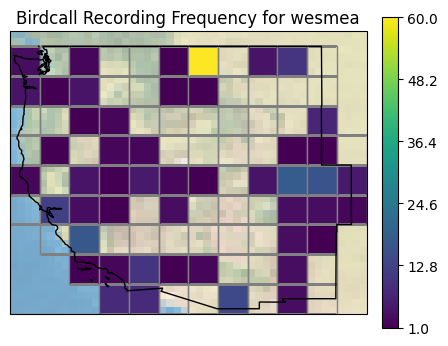

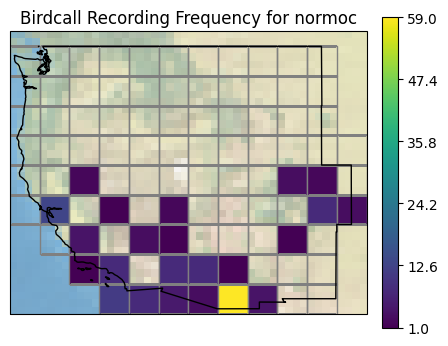

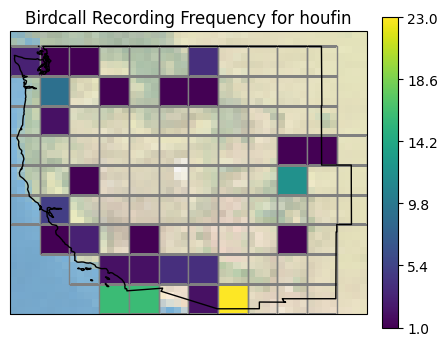

In [332]:
from birdcall_distribution.plot import dataframe_color_getter, plot_grid
from functools import partial


def plot_species(df, species, prop="y"):
    sub_df = df[df.primary_label == species]
    plot_grid(
        geometry,
        WESTERN_US_EXTENT,
        grid,
        color_callback=partial(dataframe_color_getter, sub_df, "grid_id", prop),
        vmin=sub_df[prop].min(),
        vmax=sub_df[prop].max(),
        draw_gridline=False,
        figsize=(5, 7),
    )

    plt.title(f"Birdcall Recording Frequency for {species}")
    plt.show()


def plot_ppc(prep_df, ppc, species, prop="log_pred"):
    pred_df = prep_df.copy()
    shape = prep_df.shape
    pred_df["pred"] = ppc.posterior_predictive.y.values.reshape(-1, shape[0]).mean(
        axis=0
    )
    pred_df["log_pred"] = np.log(pred_df.pred)
    pred_df = pred_df[prep_df.primary_label == species]

    plt.figure(figsize=(5, 3))
    plt.hist(pred_df[prop], bins=20)
    plt.title(f"histogram of {prop} for {species}")
    plt.show()

    print(pred_df[["primary_label", "grid_id", "pred", "log_pred"]])

    # plot the posterior predictive
    plot_grid(
        geometry,
        WESTERN_US_EXTENT,
        grid,
        color_callback=partial(dataframe_color_getter, pred_df, "grid_id", prop),
        vmin=pred_df[prop].min(),
        vmax=pred_df[prop].max(),
        draw_gridline=False,
        figsize=(5, 7),
    )
    plt.title(f"Birdcall Recording Frequency prediction for {species}")
    plt.show()


plot_species(prep_df, "wesmea")
plot_species(prep_df, "normoc")
plot_species(prep_df, "houfin")

## model

### varying intercept and slope

\begin{equation}
y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i
\end{equation}

## 

['intercept', 'population_density', 'elevation_p50', 'LST_Day_1km_p50', 'LST_Night_1km_p50']


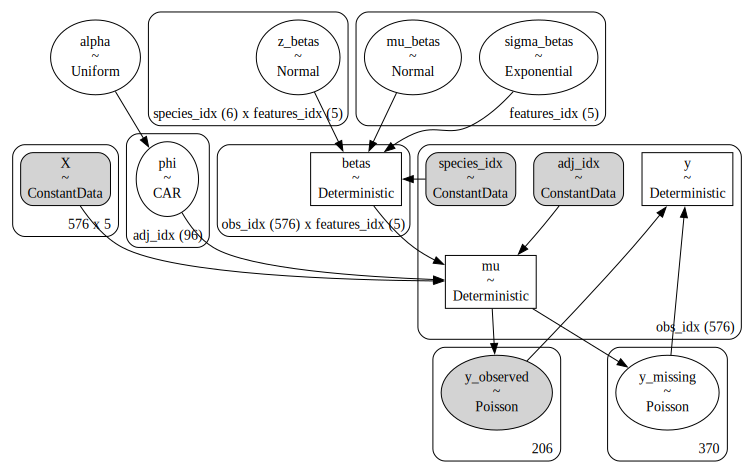

In [339]:
scaler = StandardScaler()

cols = prep_df.columns
temp_and_alt_cols = [c for c in cols if ("km" in c or "elevation" in c) and "50" in c]

data_cols = ["population_density"] + temp_and_alt_cols
temp_df = prep_df[data_cols].copy()

# add an intercept to the data cols
temp_df["intercept"] = 1
data_cols = ["intercept"] + data_cols

temp_df["population_density"] = np.log(temp_df["population_density"] + 1)
scaler.fit(temp_df)
scaled_data_df = pd.DataFrame(scaler.transform(temp_df), columns=data_cols)
print(data_cols)

species_cat = prep_df.primary_label.astype("category")
n_features = scaled_data_df.shape[1]
n_species = len(species_cat.cat.categories)
coords = dict(
    features_idx=np.arange(n_features),
    species_idx=sorted(species_cat.cat.codes.unique()),
    adj_idx=sorted(prep_df.index.unique()),
    obs_idx=np.arange(prep_df.shape[0]),
)
with pm.Model(coords=coords) as full_model:
    species_idx = pm.ConstantData("species_idx", species_cat.cat.codes, dims="obs_idx")
    adj_idx = pm.ConstantData("adj_idx", prep_df.index.values, dims="obs_idx")
    X = pm.ConstantData("X", scaled_data_df.values)

    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR(
        "phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W, dims="adj_idx"
    )

    # NOTE: reparameterization trick
    # https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html
    mu_betas = pm.Normal("mu_betas", mu=0, sigma=1, dims="features_idx")
    sigma_betas = pm.Exponential("sigma_betas", 1, dims="features_idx")
    z_betas = pm.Normal(
        "z_betas",
        mu=0,
        sigma=1,
        dims=("species_idx", "features_idx"),
    )
    betas = pm.Deterministic(
        "betas",
        mu_betas + z_betas[species_idx] * sigma_betas,
        dims=("obs_idx", "features_idx"),
    )
    mu = pm.Deterministic(
        "mu", pm.math.exp(pm.math.sum(X * betas, axis=1) + phi[adj_idx]), dims="obs_idx"
    )

    observed = np.ma.masked_invalid(prep_df.y.values)
    pm.Poisson("y", mu=mu, observed=observed, dims="obs_idx")

pm.model_to_graphviz(full_model)

In [340]:
with full_model:
    trace_full = pm.sample(1000, target_accept=0.9)
    # trace_full = pm.sample(10, tune=10, target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, phi, mu_betas, sigma_betas, z_betas]
>Metropolis: [y_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1023 seconds.


In [342]:
az.summary(trace_full, kind="stats", var_names=["~phi", "~y", "~mu", "~betas"])

,mean,sd,hdi_3%,hdi_97%
mu_betas[0],0.174,0.926,-1.620,1.843
mu_betas[1],-0.049,0.939,-1.769,1.759
mu_betas[2],0.079,0.942,-1.781,1.750
mu_betas[3],0.101,1.029,-1.701,2.085
mu_betas[4],0.053,1.007,-1.928,1.843
...,...,...,...,...
sigma_betas[0],0.504,0.212,0.227,0.880
sigma_betas[1],0.237,0.123,0.058,0.440
sigma_betas[2],0.432,0.196,0.166,0.791
sigma_betas[3],0.699,0.289,0.306,1.207


Sampling: [y_observed]


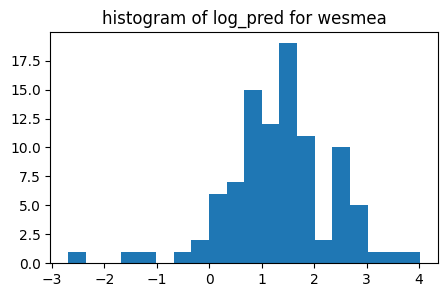

              primary_label  grid_id      pred  log_pred
adjacency_idx                                           
0                    wesmea  -103_37   5.78050  1.754490
1                    wesmea  -103_39  11.68825  2.458584
2                    wesmea  -103_41   3.90750  1.362898
3                    wesmea  -105_31   3.44550  1.237069
4                    wesmea  -105_33   2.15350  0.767094
...                     ...      ...       ...       ...
91                   wesmea  -125_39   5.09300  1.627867
92                   wesmea  -125_41   0.75450 -0.281700
93                   wesmea  -125_43   2.51150  0.920880
94                   wesmea  -125_45   4.47725  1.499009
95                   wesmea  -125_47  10.55550  2.356647

[96 rows x 4 columns]


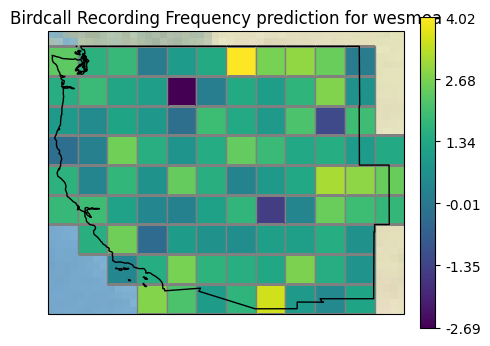

In [343]:
with full_model:
    ppc_full = pm.sample_posterior_predictive(trace_full)

plot_ppc(prep_df, ppc_full, "wesmea", "log_pred")